In [1]:
import re
import dill
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

In [2]:
import seaborn as sns
sns.set()

# Scrape race pages

In [17]:
race_ids = list(range(1, 13000))
session = FuturesSession(max_workers=8)
futures = [session.get(f'https://results.bikereg.com/race/{i}') for i in race_ids]

In [18]:
for i, future in enumerate(futures):
    dill.dump(future.result().text, open(f'C:/data/results/{i}.pkd', 'wb'))

## Extract race metadata

In [20]:
def get_data(text):
    name = ''
    date = ''
    loc = ''
    json_url = ''
    weather = ''
    strava_url = ''
    coord = None
    
    if 'No data' not in text:
        soup = BeautifulSoup(text)
        resultstitle = soup.select('div#resultstitle')[0].text
        split = resultstitle.split('•')

        regex = re.compile(r'([A-Za-z]{3})\s+(\d{1,2})\s+(\d{4})')
        name = split[0].strip()
        month, day, year = regex.findall(split[1].strip())[0]
        date = datetime.strptime(' '.join([month, day, year]), '%b %d %Y')
        loc = ''
        if len(split) > 2:
            loc = re.split('[\t\n\r]', split[2])[0].strip()
            
        json_url = soup.select('span.downloadoptions')[0].find_all('a')[1]['href']
        weather = soup.select('div#conditionssummary')[0].text.strip()
        strava_url = soup.select('div#stravasegment')[0].select('a')[1]['href']
        
        try:
            coord = re.findall(r'GetMap\("([-\d\.]+):([-\d\.]+)"', text)[0]
        except IndexError:
            pass
            
    return name, date, loc, json_url, weather, strava_url, coord

In [21]:
columns=['name', 'date', 'loc', 'json_url', 'weather', 'strava_url', 'coord']
df = pd.DataFrame(columns=columns)
for i in race_ids:  # loop takes ~2 hour or so
    if i % 100 == 0:
        print(i)
    if i in [12533, 12534]:  # these broke for some reason >:|
        continue
    text = dill.load(open(f'C:/data/results/{i}.pkd', 'rb'))
    data = get_data(text)
    df.loc[i] = {c: d for c, d in zip(columns, data)}

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900


FileNotFoundError: [Errno 2] No such file or directory: 'C:/data/results/12999.pkd'

In [22]:
df.to_pickle('C:/data/results/df.pkl')

## reload, fix some things, and resave

In [721]:
df = pd.read_pickle('C:/data/results/df.pkl')

In [5]:
df = df[df['json_url'] != '']  # drop if no results
df['weather'] = df['weather'].str.split('\n').str.get(-1)  # sometimes the weather column also got "Series: " information
df.index = df['json_url'].apply(lambda x: int(re.findall('(\d+)', x)[0]))  # find digits in url
df.index.name = 'race_id'

In [6]:
df.to_pickle('C:/data/results/df.pkl')

## reload metadata dataframe

In [722]:
df_m = pd.read_pickle('C:/data/results/df.pkl')
df_m.sample(5)

,name,date,loc,json_url,weather,strava_url,coord
race_id,,,,,,,
273,Vancouver Courthouse Criterium,2009-07-19 00:00:00,,downloadrace.php?raceID=273&json=1,,http://app.strava.com/segments/,None
244,Monday PIR August #5,2009-08-31 00:00:00,,downloadrace.php?raceID=244&json=1,,http://app.strava.com/segments/,None
4134,Squawker Road Classic - TT,2014-04-12 00:00:00,"Duango, CO",downloadrace.php?raceID=4134&json=1,"Clear, 62 degrees, wind 8 mph",http://app.strava.com/segments/,None
575,Bob Rodale Fitness Park,2010-06-27 00:00:00,,downloadrace.php?raceID=575&json=1,,http://app.strava.com/segments/,None
5782,Florida State Criterium Championships,2015-04-04 00:00:00,"Brooksville, FL",downloadrace.php?raceID=5782&json=1,"Clear, 78 degrees, wind 9 mph",http://app.strava.com/segments/,None


## Download JSON results

In [151]:
session = FuturesSession(max_workers=8)
futures = [session.get(f'https://results.bikereg.com/{url}') for url in urls]

In [159]:
# takes a few minutes (depending on caching)
for (index, url), future in zip(urls.items(), futures):
    dill.dump(future.result().text, open(f'C:/data/results/races/{index}.pkd', 'wb'))

## Load a sample race into a dataframe

In [717]:
import glob
import re
import dill
import pandas as pd
import numpy as np

In [718]:
file = r'C:\data\results\races\1000.pkd'
json = dill.load(open(file, 'rb'))

df_race = pd.read_json(json)

# drop duplicate columns
columns = [str(i) for i in range(28)]
df_race = df_race.drop(columns=columns)

race_id = re.findall('(\d+)', file)[0]
df_race['race_id'] = int(race_id)

In [719]:
df_race.head()

,RaceName,RaceCategoryName,Place,RacerID,FirstName,LastName,TeamName,RaceTime,Points,PriorPoints,...,Category,Starters,ReportedAge,CalculatedAge,RacerCount,FinishPhotoUrl,License,MetaDataUrl,ResultID,race_id
0,Swan Island Rose Festival Criterium,Category 3,1,12069,Luke,Demoe,SLOCUM Race Team,,255.000000,300.0,...,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,49081,1000
1,Swan Island Rose Festival Criterium,Category 3,2,14499,Joe,Dengel,,,258.333333,300.0,...,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,49082,1000
2,Swan Island Rose Festival Criterium,Category 3,3,14953,Daniel,Penner,Ironclad Performance Wear,,261.666667,300.0,...,3.0,NaN,NaN,25.0,31,NaN,199994.0,NaN,49083,1000
3,Swan Island Rose Festival Criterium,Category 3,4,10755,Chris,Ward,Guinness Cycling Team,,265.000000,300.0,...,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,49084,1000
4,Swan Island Rose Festival Criterium,Category 3,5,11409,Brian,Engelhard,bicycleattorney.com,,268.333333,300.0,...,2.0,NaN,NaN,36.0,31,NaN,358937.0,NaN,49085,1000


In [720]:
df_race.columns

Index(['RaceName', 'RaceCategoryName', 'Place', 'RacerID', 'FirstName',
       'LastName', 'TeamName', 'RaceTime', 'Points', 'PriorPoints',
       'RaceCategoryID', 'IsDnf', 'IsDQ', 'IsDNP', 'OffTheFront', 'OffTheBack',
       'GroupSprintPlace', 'FieldSprintPlace', 'TeamID', 'Category',
       'Starters', 'ReportedAge', 'CalculatedAge', 'RacerCount',
       'FinishPhotoUrl', 'License', 'MetaDataUrl', 'ResultID', 'race_id'],
      dtype='object')

## Now load a few races

In [283]:
df_all_races = pd.DataFrame(columns=df_race.columns)

In [284]:
for j, file in enumerate(glob.iglob(r'C:\data\results\races\*.pkd')):    
    json = dill.load(open(file, 'rb'))

    df_race = pd.read_json(json)
    if df_race.empty:
        continue
    
    # drop duplicate columns
    columns = [str(i) for i in range(28)]  # Each column repeated for some reason
    df_race = df_race.drop(columns=columns)

    race_id = re.findall('(\d+)', file)[0]
    df_race['race_id'] = int(race_id)
    
    df_all_races = pd.concat([df_all_races, df_race])
    if j == 100:
        break

In [285]:
df_all_races = df_all_races.reset_index(drop=True)

In [286]:
df_all_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21464 entries, 0 to 21463
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RaceName          21464 non-null  object 
 1   RaceCategoryName  21464 non-null  object 
 2   Place             21464 non-null  object 
 3   RacerID           21464 non-null  object 
 4   FirstName         21464 non-null  object 
 5   LastName          21464 non-null  object 
 6   TeamName          21464 non-null  object 
 7   RaceTime          21464 non-null  object 
 8   Points            19454 non-null  float64
 9   PriorPoints       19454 non-null  float64
 10  RaceCategoryID    21464 non-null  object 
 11  IsDnf             21464 non-null  object 
 12  IsDQ              17712 non-null  float64
 13  IsDNP             21464 non-null  object 
 14  OffTheFront       19855 non-null  object 
 15  OffTheBack        19855 non-null  object 
 16  GroupSprintPlace  19855 non-null  object

# Explore and process columns one-by-one

## `RaceName`, `race_id`
The `race_id` correponds to each web page, and some pages may share the same `RaceName` for races done multiple years. We can join the race metadata dataframe (`df`) with the detailed race placings (`df_all_races`) on `race_id`.

In [287]:
df['name'].value_counts()

Greenbelt Park Training Race Series                       89
PURE Driveway Series                                      63
Driveway Series                                           60
I WILL FOUNDATION Tuesday Night Race Series               55
Allegheny Cycling Assocation Wednesday Night Criterium    53
                                                          ..
Masters Road Nationals - TT                                1
Tuesday PIR April #4                                       1
Coal Miners Classic/Scott Kornfield Memorial               1
Spring Fling Crit Series #5                                1
6th Annual Speedway Grand Prix                             1
Name: name, Length: 6865, dtype: int64

## `RaceCategoryName`, `RaceCategoryID`
The category name and ID have a one-to-one correpondence and are used to split up the different fields competing. The category name will often have information about the categories of riders involved (e.g. 4/5). However, this comes in quite inconsistently, and it makes sense to use this just as a unique identifier for each field. The category ID is therefore redundant and can be dropped.

In [690]:
df_category = df_all_races.drop(columns='RaceCategoryID')

## `Place`, `IsDnf`, `IsDQ`, `IsDNP`, `OffTheFront`, `OffTheBack`, `GroupSprintPlace`, `FieldSprintPlace`
These are all columns having something to do with each individual rider's placing. Some terminology:
- "DNF" = "Did not finish": the rider did not finish the race due to a mechanical issue or injury
- "DQ" = "Disqualified": the rider broke one of the race rules (e.g. riding in the opposing lane of traffic)
- "DNP" = "Did not place": in some races (usual a short circuit course), riders at the back of the race are "pulled" early if the riders at the front of the race are going to overtake them. 
- "Off the front/back": this usually indicates some gap between groups of riders. However, these distinctions can be somewhat arbitrary and will probably not be useful for us. We can drop these columns.
- "Field/group sprint": when the entire field (or smaller group) of riders in a race finishes approximately at the same time. Unfortunately this is reported inconsistently on road-results. Some race results are marked as "sprints" if there are no reported times, so this is unlikely to give reliable information. We will drop these columns as well.

In [691]:
df_place = df_category.drop(columns=['OffTheFront', 'OffTheBack', 'GroupSprintPlace', 'FieldSprintPlace'])

Are DNF/DQ/DNP common?

In [692]:
df_place['IsDnf'].value_counts(dropna=False), df_place['IsDQ'].value_counts(dropna=False),  df_place['IsDNP'].value_counts(dropna=False), 

(0    20169
 1     1295
 Name: IsDnf, dtype: int64,
 0.0    17702
 NaN     3752
 1.0       10
 Name: IsDQ, dtype: int64,
 0    21464
 Name: IsDNP, dtype: int64)

DNF looks like it could be important - there are quite a few, as accidents are bound to happen. There do not seem to be many disqualifications, and in this subset of races, no DNPs. DNPs could happen for the same reason, so let's lump those with DNFs. Let's also put the DNP/DNF information into the place column as NaNs.

In [693]:
df_place.loc[df_place['IsDnf'] == 1, 'Place'] = np.nan
df_place.loc[df_place['IsDNP'] == 1, 'Place'] = np.nan
df_place.loc[:, 'IsDQ'] = df_place.loc[:, 'IsDQ'].fillna(0)
df_place = df_place.drop(columns=['IsDnf', 'IsDNP'])

In [694]:
df_place['Place'].value_counts(dropna=False), df_place['IsDQ'].value_counts(dropna=False)

(NaN        1295
 1.0        1131
 2.0        1048
 3.0         984
 4.0         914
            ... 
 116.0         2
 114.0         1
 121.0         1
 118.0         1
 12238.0       1
 Name: Place, Length: 121, dtype: int64,
 0.0    21454
 1.0       10
 Name: IsDQ, dtype: int64)

Some of the places look a little strainge: 12238th place? Also why is there no continuity between 118 and 121st place? Upon inspecting some of the results, listed on another website, there are indeed people placed between 118-121st place, but for some reason are not listed on road-results. The 12238 is clearly a data entry error of some sort. Let's just ignore the missing places.

## `RacerID`, `FirstName`, `LastName`, `License`, `ReportedAge`, `CalculatedAge`, `Category`
This is all information describing/identifying an individual racer, some of which may change over time. The racerID should be uniquely identified with the `FirstName + LastName`, barring any individuals with the same name. Racers may or may not have a racing licence, identified by a number. This can be used to search each racer's results [here](https://legacy.usacycling.org/events/rr.php), but this again just gives a list of results, which we should already have. Let's just drop the License. A racer's `Category` is their skill/experience level (1 (highest) to 5).

In [695]:
df_place['RacerID'].value_counts(dropna=False)

61706     33
3288      28
73220     12
16050     12
145012    12
          ..
108165     1
108163     1
59005      1
20343      1
75348      1
Name: RacerID, Length: 12491, dtype: int64

In [696]:
df_place[df_place['RacerID'] == 61706].sample(2)

,RaceName,RaceCategoryName,Place,RacerID,FirstName,LastName,TeamName,RaceTime,Points,PriorPoints,...,Category,Starters,ReportedAge,CalculatedAge,RacerCount,FinishPhotoUrl,License,MetaDataUrl,ResultID,race_id
1544,ECCC Week 6 - ECCC Championship Team Time Trial,Men Collegiate D,6,61706,,,New York University,0:28:43.43,535.0232,519.44,...,NaN,NaN,NaN,NaN,10,http://velocityresults.com/images/5281.jpg,,NaN,2588655,10006
1548,ECCC Week 6 - ECCC Championship Team Time Trial,Men Collegiate D,10,61706,,,Northeastern University,0:32:32.32,581.7728,519.44,...,NaN,NaN,NaN,NaN,10,http://velocityresults.com/images/5281.jpg,,NaN,2588659,10006


In [697]:
df_place[df_place['RacerID'] == 3288].sample(2)

,RaceName,RaceCategoryName,Place,RacerID,FirstName,LastName,TeamName,RaceTime,Points,PriorPoints,...,Category,Starters,ReportedAge,CalculatedAge,RacerCount,FinishPhotoUrl,License,MetaDataUrl,ResultID,race_id
19872,Wente Vineyards Classic Road Race,Women Cat 4/5,10,3288,Unknown,Rider,,,586.659858,424.13,...,NaN,NaN,NaN,NaN,24,NaN,,NaN,2618133,10081
13527,Whitnall Park Spring Classic,Elite Category 4/5,22,3288,Unknown,Rider,,,453.080333,443.66,...,NaN,NaN,NaN,NaN,48,NaN,,NaN,2604270,10058


The two most common RacerIDs correspond to missing racer name data, so let's drop those (along with the license column)

In [698]:
df_racer = df_place[~df_place['RacerID'].isin([3288, 61706])].drop(columns=['License'])

For the other names, let's combine the two columns into one:

In [699]:
df_racer['Name'] = df_racer['FirstName'] + ' ' + df_racer['LastName']
df_racer = df_racer.drop(columns=['FirstName', 'LastName'])

It's not clear how `ReportedAge` and `CalculatedAge` are determined, so let's just assume one or both is accurate and combine them into a single column:

In [700]:
age_cols = ['CalculatedAge', 'ReportedAge']
df_racer.loc[:, 'Age'] = df_racer[age_cols].fillna(0).max(axis=1).replace(0, np.nan)
df_racer = df_racer.drop(columns=age_cols)

Finally, category. The column already looks good.

In [701]:
df_racer['Category'].value_counts(dropna=False)

4.0    5130
3.0    4906
5.0    3594
2.0    3373
1.0    2243
NaN    2157
Name: Category, dtype: int64

## `TeamName`, `TeamID`

In [711]:
df_team = df_racer.copy()

## `RaceTime`
We would hope that this is just a time that we can format into a datetime object, however sometimes we'll see times like "s.t." or "ST" (same time as the next-highest place (i.e. finished at nearly the same time)) and of course the "DNF" we substituted in earlier. We can take the first reported time and copy that down to all other reported times. We will have to do this for each race and for each category division (see below for processing the category-related columns).

However, sometimes also the first time will be reported and all other times will be reported relative to that time. So we have to write a function to handle a few different cases of listed times.

In [710]:
df_time = df_team.copy()

In [703]:
def fix_racetime(series): # this could take a while on the full dataset
    for i, s in enumerate(series):
        series.iloc[i] = pd.to_timedelta(s, unit='s', errors='coerce')
        if pd.isnull(series.iloc[i]):
            series.iloc[i] = series.iloc[i-1]
    return series

In [704]:
df_time.groupby(['race_id', 'RaceCategoryName'])['RaceTime'].get_group()

TypeError: get_group() missing 1 required positional argument: 'name'

In [705]:
ss = df_time[(df_time['race_id'] == 10035) & (df_time['RaceCategoryID'] == 112207)]['RaceTime']
ss

KeyError: 'RaceCategoryID'

In [706]:
s2 = fix_racetime(ss)

C:\Users\Brian\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-703-5aade21eb196>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[i] = pd.to_timedelta(s, unit='s', errors='coerce')


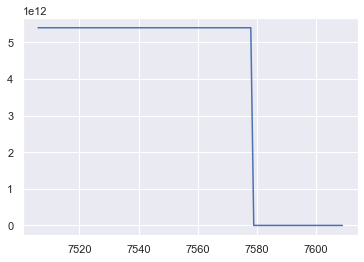

In [707]:
s2.plot()

## `Points`, `PriorPoints`
These columns list the metric used by road-results to judge the performance of racers. We probably won't use these, except to see how our method compares.

## Miscellaneous: `Starters`, `FinishPhotoUrl`, `MetaDataUrl`, `ResultID`, `RacerCount`
The result ID is a unique identifier for each row, the racer count can be easily obtained if we need it, and the other data is missing many values and is of limited importance. Drop them all.

In [728]:
df = df_time.drop(columns=['Starters', 'FinishPhotoUrl', 'MetaDataUrl', 'ResultID', 'RacerCount'])

In [729]:
df.head()

,RaceName,RaceCategoryName,Place,RacerID,TeamName,RaceTime,Points,PriorPoints,IsDQ,TeamID,Category,race_id,Name,Age
0,Saco Bay Criterium,JUNIOR 10-14,1,5705,CLNoonan/Coast to Coast/KAM,0:18:40.0,NaN,NaN,0.0,1574.0,NaN,10,Nate Morse,NaN
1,Saco Bay Criterium,JUNIOR 10-14,2,1589,,0:18:45.9,NaN,NaN,0.0,NaN,NaN,10,Tom Goguen-14,NaN
2,Saco Bay Criterium,JUNIOR 10-14,3,1591,,0:18:59.5,NaN,NaN,0.0,NaN,5.0,10,Peter Goguen,12.0
3,Saco Bay Criterium,JUNIOR 10-14,4,1671,,0:19:17.0,NaN,NaN,0.0,NaN,4.0,10,Ellen Noble,13.0
4,Saco Bay Criterium,JUNIOR 10-14,5,1672,,0:20:31.3,NaN,NaN,0.0,NaN,NaN,10,David Terwilliger-13,NaN


What columns are probably useless? RaceCategoryID seems to just be a numerical label for the RaceCategoryName, which can appear many different ways to describe the same type of field.

In [10]:
df_all_races.groupby(['RaceCategoryID', 'RaceCategoryName']).size()[:10]

RaceCategoryID  RaceCategoryName    
85              JUNIOR 15-18             7
86              MEN CAT 1/2             32
87              WOMEN CAT 4              4
88              MASTER 55/65             7
89              MASTERS 35              36
90              MASTER 45               25
91              MEN CAT 3               23
92              WOMEN CAT 1/2/3          7
93              MEN CAT 4/5 34 UNDER    22
94              MEN CAT 4/5 35 OVER     21
dtype: int64

We can also drop MetaDataUrl and FinishPhotoUrl (lack of data, and it wouldn't be useful anyway) and ResultID (redundant unique label for each row).

In [11]:
df_all_races.shape, df_all_races['ResultID'].nunique()

((21464, 29), 21464)

In [12]:
df_all_races = df_all_races.drop(columns=['RaceCategoryID', 'MetaDataUrl', 'FinishPhotoUrl', 'ResultID'])

We now need to deal with the race category name. This will specify the level of experience of racers (from high to low: Pro/P, 1, 2, 3, 4, 5, or collegiate A, B, C, D) and may also indicate gender or age splits (men, women, master, junior). Let's inspect all the possibilities:

In [13]:
df_all_races['RaceCategoryName'].unique()

array(['JUNIOR 10-14', 'JUNIOR 15-18', 'MASTER 45', 'MASTER 55/65',
       'MASTERS 35', 'MEN CAT 1/2', 'MEN CAT 3', 'MEN CAT 4/5 34 UNDER',
       'MEN CAT 4/5 35 OVER', 'WOMEN CAT 1/2/3', 'WOMEN CAT 4',
       'Masters 35+       ', 'Masters 45+       ',
       'Men 3/4                 ', 'Men 4                   ',
       'Men 4/5 ( <35 )         ', 'Men 4/5 ( 35+ )         ',
       'Pro 1/2                 ', 'Women 4                ',
       'Women Pro/1/2/3         ', 'Category 3', 'Juniors 10-13',
       'Juniors 14-18', 'Masters 35+ 1/2/3', 'Masters 50+',
       'Masters Cat 4/5', 'Men Cat 4/5', 'Senior Men', 'Women 1/2/3',
       'Women Cat 4', 'Men Collegiate CAT A', 'Men Collegiate CAT B',
       'Men Collegiate CAT C', 'Women Collegiate CAT A',
       'Women Collegiate CAT B', 'Men Masters 35-44 Cat 1/2/3/4',
       'Men Masters 45+ Cat 1/2/3/4', 'Men Masters 50-59 Open',
       'Men Masters 60+', 'Men Pro/Cat 1/2/3', 'Women Open', 'Elite Men',
       'Elite Women', 'Fat Bi

Using regex, it should be fairly straightforward to extract gender and the usual categories (which appear as single digits or letters). Age ranges will be more difficult.

In [59]:
def extract_gender(s):
    matches = re.findall(r'(women|men)', s.lower())
    if len(matches) == 1:
        if matches[0] == 'women':
            return 'F'
        else:
            return 'M'
    return None
    
def extract_category(s):
    categories = []
    matches = re.findall(r'(\d+)', s)
    for match in sorted(matches, key=lambda x: int(x)):  # sort by integer value, but keep it a string
        print(match)
        if match in '12345':
            if match in ('34', '45'):  # e.g. "cat 45" or "master 45+"
                if len(categories) == 0:  # we haven't yet identified a category
#                     if 'master' not in s.lower():
                    categories.extend(int(m) for m in match)
                else:
                    continue
            else:
                categories.extend(match)
    if 'junior' in s.lower() or 'school' in s.lower():
        categories.extend('J')
    if 'master' in s.lower() or 'senior' in s.lower():
        categories.extend('M')
    if 'pro' in s.lower():
        categories.extend('P')
        
    # Collegiate? Intermediate?
        
    return categories

extract_gender('Women'), extract_category('Men 3/4 45+ 55+'), extract_category('MEN CAT 4/5 34 UNDER') #extract_category('Men 45+ 55+')

3
4
45
55
4
5
34


('F', ['3', '4'], ['4', '5'])

In [60]:
df_all_races['gender'] = df_all_races['RaceCategoryName'].apply(extract_gender)
df_all_races['category'] = df_all_races['RaceCategoryName'].apply(extract_category)

10
14
10
14
10
14
10
14
10
14
10
14
10
14
10
14
15
18
15
18
15
18
15
18
15
18
15
18
15
18
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
55
65
55
65
55
65
55
65
55
65
55
65
55
65
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
34
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
4
4
4
4
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
45
45
45
45
45
45
45
45
4

4
5
35
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
55
55
55
55
55
55
55
55
55
55
55
55
55
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
35
35
35
35
35
50
50
50
1
2
3
1
2
3
1
2
3
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
35
99
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
4
4
4
4
4
4
4
4
4
4
4
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
4
35
4
35
4
35
4
35
4
35
4
35
4
35
4
35
4
35
4
35
4
35
4
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
5
35
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
4
45
5
45
5
45
5
45
5
45
5
45
5
45
5
45
5
45
5
45
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
35
123
35
123
35
123
35
123
35
123

99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
45
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
1
2
3
4
55
99
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35
99
4
35


18
2
12
18
2
12
18
2
12
18
19
19
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
3
13
14
1
15
18
1
15
18
1
15
18
1
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
15
18
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
1
19
34
2
19
34
2
19
34
2
19
34
2
19
34
2
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
3
19
34
1
35
1
35
1
35
2
35
2
35
2
35
2
35
3
35
3
35
3
35
2
12
18
2
12
18
3
13
14
3
13
14
1
15
18
3
15
18
3
15
18
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
3
9
12
1
1
1
1
1
1
1
1
1
1
1
2
3
4
40
1
2
3
4
40
1
2
3
4
40
1
2
3
4
40
1
2
3
4
40
1
2
3


3
4
55
1
2
3
4
55
1
2
3
4
55
1
2
3
4
55
1
2
3
4
55
1
2
3
4
55
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
15
18
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3
35
99
1
2
3


3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
3
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
5
4
5
4
5
4
5


14
13
14
15
16
15
16
15
16
17
18
1
2
3
40
1
2
3
40
1
2
3
40
1
2
3
40
1
2
3
40
1
2
3
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
4
5
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
60
60
60
60
60
60
60
60
60
60
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
3
3
3
3
3
3
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
17
18
17
18
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
1
2
3
40
1
2
3
40
1
2
3
40
3
3
4
5
4
5
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
1
4
35
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
45
54
45
54
65
74
65
74
75
55
64
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
4
5
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
3
15
18
3
15
18
3
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
4
5
15
18
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
1
2
3
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
4
5
35
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
45
1
2
3
55
1
2
3
55
1
2
3
55
1
2
3
55
1
2
3
55
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3

In [61]:
df_all_races['category'].value_counts()

[M]                   2064
[]                    1976
[3]                   1601
[4]                   1450
[1, 2, 3, M]          1213
[4, 5]                1147
[5]                   1112
[1, 2, P]              933
[1, 2, 3]              840
[4, 5, M]              738
[1, 2, 3, 4, M]        702
[4, M]                 635
[1, P]                 612
[3, 4]                 565
[1, 2]                 550
[1, 2, M]              526
[4, 5, M]              503
[5, M]                 459
[3, M]                 452
[J]                    379
[2]                    361
[1, 2, 3, P]           321
[3, 4, M]              235
[1]                    221
[3, 4, 5]              212
[2, 3]                 206
[1, 1, 2, P]           176
[3, 4, 5, M]           173
[1, 2, 3, 4, 5, J]     112
[3, J]                 100
[1, 2, 3, M, P]         96
[1, 2, M, P]            95
[1, 1, 2, 2, 3, 3]      90
[3, 3, 4]               89
[1, 2, 3, 4, 5, M]      71
[3, 1, 2, J]            60
[4, 5, 1, 2, 3, M]      59
[

In [81]:
df_all_races[['RaceCategoryName', 'category']].sample(5)

,RaceCategoryName,category
99,Masters 45+,"[4, 5, M]"
25,Men Master 45+ Cat 123,"[4, 5, 1, 2, 3, M]"
454,Women Cat1/2/3 Category 1/2/3,"[1, 1, 2, 2, 3, 3]"
306,Men Pro/C1,"[1, P]"
145,Men Cat2 50+,[2]


In [62]:
j = 230
df_all_races[df_all_races['category'].isin([[4, 5, 1, 2, 3, "M"]])][['RaceCategoryName', 'category']]

SystemError: <built-in method view of numpy.ndarray object at 0x000002A878B86350> returned a result with an error set

In [57]:
df_all_races[['RaceCategoryName', 'category']].sample(5)

,RaceCategoryName,category
48,Men Merckx Cat 5,[5]
222,Men Senior Open Cat 1/2,"[1, 2]"
168,Men Cat3/4 Category 3,"[3, 3, 4]"
53,Men Cat 3/4,"[3, 4]"
340,Women Cat 4,[4]


In [58]:
df_all_races.loc[168]

,RaceName,RaceCategoryName,Place,RacerID,FirstName,LastName,TeamName,RaceTime,Points,PriorPoints,...,TeamID,Category,Starters,ReportedAge,CalculatedAge,RacerCount,License,race_id,gender,category
168,Saco Bay Criterium,MEN CAT 4/5 35 OVER,9,1662,Liam,Somers,BASE36/SMCC,0:30:06.1,433.738328,450.000000,...,1157.0,4.0,NaN,NaN,39.0,21,194532,10,M,"[4, 5]"
168,The 15th Annual MRC Sterling Classic Road Race,Men 3/4,56,1007,Justin,Bourque,bikebarnracing.com,0:03:27,350.858441,300.310000,...,1009.0,3.0,NaN,NaN,34.0,69,187412,100,M,"[3, 4]"
168,Swan Island Rose Festival Criterium,Men Cat 4/5,43,36416,Jerome,Leedy,,,505.760870,450.000000,...,3257.0,NaN,NaN,NaN,NaN,47,NaN,1000,M,"[4, 5]"
168,Ossian Giant Gravel Grinder Featuring Jeremy P...,Men's Masters 50 Plus,41,11823,David,Dickson,Vertical Team Slipstream,5:22:21,524.114603,450.000000,...,55456.0,NaN,NaN,NaN,NaN,41,,10002,M,[M]
168,ECCC Week 6 - ECCC Championship Road Race,Men Collegiate D,999,161085,Brandon,Loo,University of Connecticut,DNF,706.304251,702.368099,...,2430.0,NaN,NaN,NaN,NaN,67,552425,10007,M,[]
168,Carl Dolan Memorial/Howard County Library Spri...,Men Cat3/4 Category 3,48,15307,Collin,Magnetti,Artemis Racing,,446.898307,404.921484,...,6218.0,3.0,NaN,33.0,33.0,89,272404,10008,M,"[3, 3, 4]"
168,East Canyon-Echo Road Race,Men Masters 55+,10,51450,Charles,Palmer,FFKR ARCHITECTS RACING,2:11:14,543.457917,455.680000,...,15768.0,3.0,NaN,NaN,62.0,13,156926,10009,M,[M]
168,Merco Cycling Classic - TT,Men Pro/1/2,113,16527,Elliot,Jaramillo,McGuire Cycling Team,31:58.4,199.943211,171.229936,...,8407.0,2.0,NaN,NaN,37.0,115,179930,1001,M,"[1, 2, P]"
168,ECCC Week 6 - ECCC Championships Criterium,Women Collegiate C,12,161139,Camryn,Kluetmeier,Middlebury College,1 Lap,665.894550,552.480000,...,2884.0,5.0,NaN,NaN,19.0,14,550813,10010,F,[]
168,Daniel Harwi Memorial 31th Annual Lower Provid...,Men Cat 1/2/3,19,161324,Graham,Watters,Lateral stress velo,12:47.4,368.356687,348.491190,...,3513.0,3.0,NaN,NaN,27.0,93,551702,10014,M,"[1, 2, 3]"


In [85]:
df_all_races.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21464 entries, 0 to 55
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RaceName          21464 non-null  object 
 1   RaceCategoryName  21464 non-null  object 
 2   Place             21464 non-null  object 
 3   RacerID           21464 non-null  object 
 4   FirstName         21464 non-null  object 
 5   LastName          21464 non-null  object 
 6   TeamName          21464 non-null  object 
 7   RaceTime          21464 non-null  object 
 8   Points            19454 non-null  float64
 9   PriorPoints       19454 non-null  float64
 10  IsDnf             21464 non-null  object 
 11  IsDQ              17712 non-null  float64
 12  IsDNP             21464 non-null  object 
 13  OffTheFront       19855 non-null  object 
 14  OffTheBack        19855 non-null  object 
 15  GroupSprintPlace  19855 non-null  object 
 16  FieldSprintPlace  16426 non-null  float64
 

In [115]:
df_all_races['RaceCategoryName'].str.extractall('(\d+)')[0].unique()

array(['10', '14', '15', '18', '45', '55', '65', '35', '1', '2', '3', '4',
       '5', '34', '13', '50', '44', '59', '60', '16', '19', '11', '12',
       '9', '99', '49', '40', '123', '12345', '17', '39', '64', '69',
       '70', '74', '75', '79', '30', '22', '23', '29', '54'], dtype=object)

In [17]:
df_all_races['RaceCategoryName'].nunique(), df_all_races['RaceCategoryID'].nuniq

(707, 1134)

In [19]:
df_all_races.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21464 entries, 0 to 55
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RaceName          21464 non-null  object 
 1   RaceCategoryName  21464 non-null  object 
 2   Place             21464 non-null  object 
 3   RacerID           21464 non-null  object 
 4   FirstName         21464 non-null  object 
 5   LastName          21464 non-null  object 
 6   TeamName          21464 non-null  object 
 7   RaceTime          21464 non-null  object 
 8   Points            19454 non-null  float64
 9   PriorPoints       19454 non-null  float64
 10  RaceCategoryID    21464 non-null  object 
 11  IsDnf             21464 non-null  object 
 12  IsDQ              17712 non-null  float64
 13  IsDNP             21464 non-null  object 
 14  OffTheFront       19855 non-null  object 
 15  OffTheBack        19855 non-null  object 
 16  GroupSprintPlace  19855 non-null  object 
 

In [42]:
df_race1 = df_all_races[df_all_races['race_id']==10]

In [46]:
df_race1[['RaceCategoryName', 'RaceCategoryID']]

,RaceCategoryName,RaceCategoryID
0,JUNIOR 10-14,95
1,JUNIOR 10-14,95
2,JUNIOR 10-14,95
3,JUNIOR 10-14,95
4,JUNIOR 10-14,95
...,...,...
187,WOMEN CAT 1/2/3,92
188,WOMEN CAT 4,87
189,WOMEN CAT 4,87
190,WOMEN CAT 4,87


In [44]:
df_race1

,RaceName,RaceCategoryName,Place,RacerID,FirstName,LastName,TeamName,RaceTime,Points,PriorPoints,...,Category,Starters,ReportedAge,CalculatedAge,RacerCount,FinishPhotoUrl,License,MetaDataUrl,ResultID,race_id
0,Saco Bay Criterium,JUNIOR 10-14,1,5705,Nate,Morse,CLNoonan/Coast to Coast/KAM,0:18:40.0,NaN,NaN,...,NaN,NaN,NaN,NaN,8,NaN,235572,NaN,1778,10
1,Saco Bay Criterium,JUNIOR 10-14,2,1589,Tom,Goguen-14,,0:18:45.9,NaN,NaN,...,NaN,NaN,NaN,NaN,8,NaN,None,NaN,1779,10
2,Saco Bay Criterium,JUNIOR 10-14,3,1591,Peter,Goguen,,0:18:59.5,NaN,NaN,...,5.0,NaN,NaN,12.0,8,NaN,234564,NaN,1780,10
3,Saco Bay Criterium,JUNIOR 10-14,4,1671,Ellen,Noble,,0:19:17.0,NaN,NaN,...,4.0,NaN,NaN,13.0,8,NaN,282412,NaN,1781,10
4,Saco Bay Criterium,JUNIOR 10-14,5,1672,David,Terwilliger-13,,0:20:31.3,NaN,NaN,...,NaN,NaN,NaN,NaN,8,NaN,None,NaN,1782,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Saco Bay Criterium,WOMEN CAT 1/2/3,7,1648,Cathy,Rowell,NEBC/Cycle Loft/Devonshire Dent,0:34:41.4,NaN,NaN,...,2.0,NaN,NaN,40.0,7,NaN,146312,NaN,1734,10
188,Saco Bay Criterium,WOMEN CAT 4,1,695,Natalia,Gardiol,MIT / FXDD,0:26:54.4,NaN,NaN,...,4.0,NaN,NaN,31.0,4,NaN,235753,NaN,1915,10
189,Saco Bay Criterium,WOMEN CAT 4,2,209,Katherine,Snell,NEBC/Cycle Loft/Devonshire Dent,0:26:54.5,NaN,NaN,...,4.0,NaN,NaN,45.0,4,NaN,272673,NaN,1916,10
190,Saco Bay Criterium,WOMEN CAT 4,3,1605,Margaret,Moore,,0:27:07.6,NaN,NaN,...,4.0,NaN,NaN,30.0,4,NaN,188961,NaN,1917,10
